# <p style="padding:10px;background-color:#87CEEB ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:50">2. Model Training for Used Car Dataset - Bhoye Manish Dattu</p>

### Loading the necessary Libraries

In [3]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Modelling
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

# <p style="padding:10px;background-color:#87CEEB ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:50">Read the Dataset</p>

In [4]:
df = pd.read_csv('used_car_dataset.csv')
df.head()

,Brand,model,Year,Age,kmDriven,Transmission,Owner,FuelType,PostedDate,AdditionInfo,AskPrice
0,Honda,City,2001,23,"98,000 km",Manual,second,Petrol,Nov-24,"Honda City v teck in mint condition, valid gen...","₹ 1,95,000"
1,Toyota,Innova,2009,15,190000.0 km,Manual,second,Diesel,Jul-24,"Toyota Innova 2.5 G (Diesel) 7 Seater, 2009, D...","₹ 3,75,000"
2,Volkswagen,VentoTest,2010,14,"77,246 km",Manual,first,Diesel,Nov-24,"Volkswagen Vento 2010-2013 Diesel Breeze, 2010...","₹ 1,84,999"
3,Maruti Suzuki,Swift,2017,7,"83,500 km",Manual,second,Diesel,Nov-24,Maruti Suzuki Swift 2017 Diesel Good Condition,"₹ 5,65,000"
4,Maruti Suzuki,Baleno,2019,5,"45,000 km",Automatic,first,Petrol,Nov-24,"Maruti Suzuki Baleno Alpha CVT, 2019, Petrol","₹ 6,85,000"


# <p style="padding:10px;background-color:#87CEEB ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:50">Getting X and Y variables</p>

In [6]:
X = df.drop(labels=['AskPrice'], axis=1)
Y = df[['AskPrice']]

# <p style="padding:10px;background-color:#87CEEB ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:50">Creating Data Transformation Pipeline</p>

### Creating Pipeline with Column Transformer

In [7]:
# Define which columns should be ordinal-encoded and which should be scaled
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(exclude='object').columns


# Define the custom ranking for ordinal variables in used car dataset
owner_categories = [
    'First Owner',
    'Second Owner',
    'Third Owner',
    'Fourth Owner'
]

condition_categories = [
    'Poor',
    'Average',
    'Good',
    'Excellent'
]


from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler


# Numerical Pipeline
num_pipeline = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)


# Categorical Pipeline
cat_pipeline = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ordinal_encoder', OrdinalEncoder(
            categories=[owner_categories, condition_categories]
        )),
        ('scaler', StandardScaler())
    ]
)


# Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num_pipeline', num_pipeline, numerical_cols),
        ('cat_pipeline', cat_pipeline, categorical_cols)
    ]
)


# <p style="padding:10px;background-color:#87CEEB ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:50">Train Test Split</p>

In [8]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X,Y,test_size=0.2,random_state=42)

# <p style="padding:10px;background-color:#87CEEB ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:50">Transforming the data with pipeline created</p>

In [9]:
# Clean 'kmDriven' column for numerical processing
def clean_kmDriven(df_col):
    return df_col.astype(str).str.replace(' km', '').str.replace(',', '').astype(float)

xtrain['kmDriven'] = clean_kmDriven(xtrain['kmDriven'])
xtest['kmDriven'] = clean_kmDriven(xtest['kmDriven'])

# Standardize 'Owner' column values to match predefined categories
owner_mapping = {
    'first': 'First Owner',
    'second': 'Second Owner',
    'third': 'Third Owner',
    'fourth': 'Fourth Owner',
    'First Owner': 'First Owner', # Ensure consistency if already correct
    'Second Owner': 'Second Owner',
    'Third Owner': 'Third Owner',
    'Fourth Owner': 'Fourth Owner'
}
xtrain['Owner'] = xtrain['Owner'].map(owner_mapping).fillna(xtrain['Owner'])
xtest['Owner'] = xtest['Owner'].map(owner_mapping).fillna(xtest['Owner'])


# Redefine ColumnTransformer components based on the used car dataset
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

# Identify columns for each type of transformation
numerical_cols = ['Year', 'Age', 'kmDriven']
ordinal_cols = ['Owner']
nominal_cols = ['Brand', 'model', 'Transmission', 'FuelType', 'PostedDate', 'AdditionInfo']

# Numerical Pipeline
num_pipeline = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

# Ordinal Pipeline for 'Owner' column
ordinal_pipeline = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ordinal_encoder', OrdinalEncoder(categories=[owner_categories])),
        ('scaler', StandardScaler())
    ]
)

# One-Hot Encoding Pipeline for other nominal categorical features
onehot_pipeline = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot_encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]
)

# Recreate the Column Transformer with appropriate pipelines for each column type
preprocessor = ColumnTransformer(
    transformers=[
        ('num_pipeline', num_pipeline, numerical_cols),
        ('ordinal_pipeline', ordinal_pipeline, ordinal_cols),
        ('onehot_pipeline', onehot_pipeline, nominal_cols)
    ],
    remainder='passthrough' # Keep any other columns not explicitly transformed
)

# Apply the transformation
xtrain = pd.DataFrame(preprocessor.fit_transform(xtrain),columns=preprocessor.get_feature_names_out())
xtest = pd.DataFrame(preprocessor.transform(xtest),columns=preprocessor.get_feature_names_out())

In [10]:
preprocessor.get_feature_names_out()

array(['num_pipeline__Year', 'num_pipeline__Age',
       'num_pipeline__kmDriven', ...,
       'onehot_pipeline__AdditionInfo_पैसे की  इमरजेंसी है Volkswagen Polo 2013 Diesel 100000 Km Driven',
       'onehot_pipeline__AdditionInfo_सेंट्रो कार',
       'onehot_pipeline__AdditionInfo_ਗੱਡੀ ਬਿਲਕੁਲ ਸਾਫ ਹੈ ਸਰਵਿਸ ਹੋਈ ਹੈ'],
      shape=(6520,), dtype=object)

In [11]:
xtrain.head()

,num_pipeline__Year,num_pipeline__Age,num_pipeline__kmDriven,ordinal_pipeline__Owner,onehot_pipeline__Brand_Ambassador,onehot_pipeline__Brand_Ashok,onehot_pipeline__Brand_Aston Martin,onehot_pipeline__Brand_Audi,onehot_pipeline__Brand_BMW,onehot_pipeline__Brand_Bajaj,...,onehot_pipeline__AdditionInfo_honda accord 2.4 i-vtec KL reg,onehot_pipeline__AdditionInfo_honda jazz,onehot_pipeline__AdditionInfo_modified Honda Civic 2008 CNG & Hybrids 10 Km Driven,onehot_pipeline__AdditionInfo_urgent foreign ja rahe hai is karke sale karni hai,onehot_pipeline__AdditionInfo_well maintained i20 for sale,onehot_pipeline__AdditionInfo_गाड़ी फुल कंडीशन में हे कोई काम नहीं करना पड़ेगा,onehot_pipeline__AdditionInfo_पुरानी स्क्रैप की गाड़ी बेचने के लिए संपर्क करें,onehot_pipeline__AdditionInfo_पैसे की इमरजेंसी है Volkswagen Polo 2013 Diesel 100000 Km Driven,onehot_pipeline__AdditionInfo_सेंट्रो कार,onehot_pipeline__AdditionInfo_ਗੱਡੀ ਬਿਲਕੁਲ ਸਾਫ ਹੈ ਸਰਵਿਸ ਹੋਈ ਹੈ
0,1.632357,-1.632357,-0.995782,-0.990004,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.088353,0.088353,0.328479,-0.990004,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.825799,0.825799,0.225289,1.010097,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.386541,-1.386541,-0.651819,-0.990004,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.894910,-0.894910,-0.359449,-0.990004,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
xtest.head()

,num_pipeline__Year,num_pipeline__Age,num_pipeline__kmDriven,ordinal_pipeline__Owner,onehot_pipeline__Brand_Ambassador,onehot_pipeline__Brand_Ashok,onehot_pipeline__Brand_Aston Martin,onehot_pipeline__Brand_Audi,onehot_pipeline__Brand_BMW,onehot_pipeline__Brand_Bajaj,...,onehot_pipeline__AdditionInfo_honda accord 2.4 i-vtec KL reg,onehot_pipeline__AdditionInfo_honda jazz,onehot_pipeline__AdditionInfo_modified Honda Civic 2008 CNG & Hybrids 10 Km Driven,onehot_pipeline__AdditionInfo_urgent foreign ja rahe hai is karke sale karni hai,onehot_pipeline__AdditionInfo_well maintained i20 for sale,onehot_pipeline__AdditionInfo_गाड़ी फुल कंडीशन में हे कोई काम नहीं करना पड़ेगा,onehot_pipeline__AdditionInfo_पुरानी स्क्रैप की गाड़ी बेचने के लिए संपर्क करें,onehot_pipeline__AdditionInfo_पैसे की इमरजेंसी है Volkswagen Polo 2013 Diesel 100000 Km Driven,onehot_pipeline__AdditionInfo_सेंट्रो कार,onehot_pipeline__AdditionInfo_ਗੱਡੀ ਬਿਲਕੁਲ ਸਾਫ ਹੈ ਸਰਵਿਸ ਹੋਈ ਹੈ
0,-0.579984,0.579984,0.032429,-0.990004,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.825799,0.825799,0.500461,1.010097,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.579984,0.579984,-0.600224,-0.990004,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.386541,-1.386541,0.070506,-0.990004,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.140726,-1.140726,0.173695,-0.990004,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# <p style="padding:10px;background-color:#87CEEB ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:50">Model Training Baseline models</p>

### Create an Evaluate Function to give all metrics after model Training

In [13]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

### Training Various models

In [14]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(),
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

# Function to clean the target variable
def clean_ask_price(df_col):
    return df_col.astype(str).str.replace('₹', '').str.replace(',', '').astype(float)

# Apply cleaning to ytrain and ytest
ytrain['AskPrice'] = clean_ask_price(ytrain['AskPrice'])
ytest['AskPrice'] = clean_ask_price(ytest['AskPrice'])

# Clean feature names for XGBoost compatibility
def clean_feature_names(df):
    cols = df.columns
    new_cols = []
    for col in cols:
        new_col = col.replace('[', '').replace(']', '').replace('<', '')
        new_cols.append(new_col)
    df.columns = new_cols
    return df

xtrain = clean_feature_names(xtrain)
xtest = clean_feature_names(xtest)

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(xtrain, ytrain.values.flatten()) # Train model

    # Make predictions
    y_train_pred = model.predict(xtrain)
    y_test_pred = model.predict(xtest)

    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(ytrain, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(ytest, y_test_pred)


    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])

    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')

    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)

    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 86248.6982
- Mean Absolute Error: 22038.9329
- R2 Score: 0.9973
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 815377.4613
- Mean Absolute Error: 260308.5816
- R2 Score: 0.7520




/home/manish/Documents/ML_PROJECT/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.868e+13, tolerance: 2.121e+12
  model = cd_fast.enet_coordinate_descent(


Lasso
Model performance for Training set
- Root Mean Squared Error: 86618.5520
- Mean Absolute Error: 27286.4589
- R2 Score: 0.9973
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 798528.3580
- Mean Absolute Error: 238379.2572
- R2 Score: 0.7621


Ridge
Model performance for Training set
- Root Mean Squared Error: 367122.9768
- Mean Absolute Error: 155578.0053
- R2 Score: 0.9513
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 817529.9566
- Mean Absolute Error: 310956.7781
- R2 Score: 0.7507


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 825458.5837
- Mean Absolute Error: 204437.0399
- R2 Score: 0.7538
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 900458.7583
- Mean Absolute Error: 262402.6057
- R2 Score: 0.6975


Decision Tree
Model performance for Training set
- Root Mean Squared Error: 11554.5667
- Mean Absolut

### Results

In [ ]:
df_results = pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)
df_results

,Model Name,R2_Score
6,XGBRegressor,0.840378
7,CatBoosting Regressor,0.826435
5,Random Forest Regressor,0.793842
1,Lasso,0.762121
0,Linear Regression,0.751976
2,Ridge,0.750665
4,Decision Tree,0.726374
3,K-Neighbors Regressor,0.697986
8,AdaBoost Regressor,-0.139060


# <p style="padding:10px;background-color:#87CEEB ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:50">Hyperparameter tuning</p>

### Tuning Catboost

In [ ]:
# Initializing catboost
cbr = CatBoostRegressor(verbose=False)

# Creating the hyperparameter grid
param_dist = {'depth'          : [4,5,6,7,8,9, 10],
              'learning_rate' : [0.01,0.02,0.03,0.04],
               'iterations'    : [300,400,500,600]}

#Instantiate RandomSearchCV object
rscv = RandomizedSearchCV(cbr , param_dist, scoring='r2', cv =5, n_jobs=-1)

# Fit the model
rscv.fit(xtrain, ytrain.values.flatten())

# Print the tuned parameters and score
print(rscv.best_params_)
print(rscv.best_score_)

{'learning_rate': 0.04, 'iterations': 400, 'depth': 9}
0.703098946503997


### Definition to print evaluated model results

In [ ]:
def print_evaluated_results(model,xtrain,ytrain,xtest,ytest):
    ytrain_pred = model.predict(xtrain)
    ytest_pred = model.predict(xtest)

    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(ytrain, ytrain_pred)
    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(ytest, ytest_pred)

    # Printing results
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')

    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))

In [ ]:
# Selecting best model
best_cbr = rscv.best_estimator_

# Evaluate Train and Test dataset
print_evaluated_results(best_cbr,xtrain,ytrain,xtest,ytest)

Model performance for Training set
- Root Mean Squared Error: 484416.3120
- Mean Absolute Error: 280086.3780
- R2 Score: 0.9152
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 769390.2615
- Mean Absolute Error: 313988.9297
- R2 Score: 0.7792


### Tuning KNN

In [ ]:
from sklearn.model_selection import GridSearchCV
# Initialize knn
knn = KNeighborsRegressor()

# parameters
k_range = list(range(2, 31))
param_grid = dict(n_neighbors=k_range)

# Fitting the cvmodel
grid = GridSearchCV(knn, param_grid, cv=5, scoring='r2',n_jobs=-1)
grid.fit(xtrain, ytrain)

# Print the tuned parameters and score
print(grid.best_params_)
print(grid.best_score_)

{'n_neighbors': 2}
0.6641194151810287


In [ ]:
# Selecting best model
best_knn = grid.best_estimator_

# Evaluate Train and Test dataset
print_evaluated_results(best_knn,xtrain,ytrain,xtest,ytest)

Model performance for Training set
- Root Mean Squared Error: 524940.5224
- Mean Absolute Error: 121532.7639
- R2 Score: 0.9004
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 713477.0114
- Mean Absolute Error: 225541.6581
- R2 Score: 0.8101


### Tuning XGBoost

In [ ]:
# Initializing xgboost
xgb = XGBRegressor()

# Parameters
params = {
 'learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],
 'max_depth' : [ 3, 4, 5, 6, 8, 10, 12, 15],
 'min_child_weight' : [ 1, 3, 5, 7 ],
 'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 'colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7 ],
 'n_estimators':[300,400,500,600]
}

rs_xgb=RandomizedSearchCV(xgb,param_distributions=params,scoring='r2',n_jobs=-1,cv=5)
rs_xgb.fit(xtrain, ytrain.values.flatten())

# Print the tuned parameters and score
print(rs_xgb.best_params_)
print(rs_xgb.best_score_)

{'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 0.4}
0.7538119984946705


In [ ]:
# Selecting best xgb model
best_xgb = rs_xgb.best_estimator_

# Evaluate Train and Test dataset
print_evaluated_results(best_xgb,xtrain,ytrain,xtest,ytest)

Model performance for Training set
- Root Mean Squared Error: 99371.9645
- Mean Absolute Error: 71859.5234
- R2 Score: 0.9964
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 635038.5608
- Mean Absolute Error: 189664.7344
- R2 Score: 0.8496


# <p style="padding:10px;background-color:#87CEEB ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:50">Voting Regressor</p>

In [ ]:
from sklearn.ensemble import VotingRegressor

er = VotingRegressor([('cbr',best_cbr),('knn',best_knn),('xgb',XGBRegressor())], weights=[3,1,2])
er.fit(xtrain, ytrain.values.flatten())

print_evaluated_results(er,xtrain,ytrain,xtest,ytest)

Model performance for Training set
- Root Mean Squared Error: 364160.7158
- Mean Absolute Error: 203107.5366
- R2 Score: 0.9521
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 668126.0535
- Mean Absolute Error: 256786.8277
- R2 Score: 0.8335


### Model improved with Ensemble technique !

# <p style="padding:10px;background-color:#87CEEB ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:50">Catboost Model Feature Importances</p>

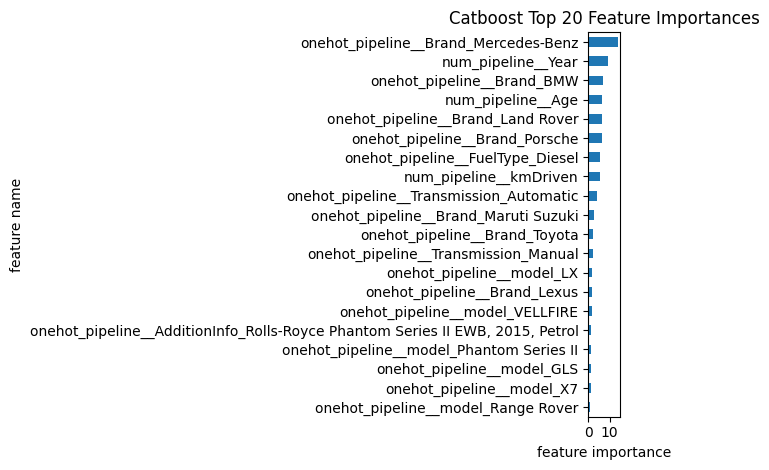

In [ ]:
feature_imp = best_cbr.feature_importances_
feature_nm = best_cbr.feature_names_
imp_series = pd.Series(feature_imp)
imp_series.index = feature_nm

# Filter for top N features and plot
top_n = 20 # You can adjust this number
imp_series.nlargest(top_n).sort_values().plot(kind='barh',
                              xlabel='feature importance',
                              ylabel='feature name',
                              title='Catboost Top {} Feature Importances'.format(top_n))
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()